In [1]:
### Lectures des donnees et fonctions
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA
mae.rmse <- function(m, m.hat) {
    return(list(mae=mean(abs(m - m.hat), na.rm=T), rmse=sqrt(mean((m - m.hat)^2, na.rm=T))))
}
new.m.mae.rmse <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae.rmse(m.svd2, m)
    }

In [2]:
# fonction de reduction de dimensions et calcul de MAE
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)+r.means
mae(m.svd2[i.test.b], m.na[i.test.b])
    }


In [3]:
library('matrixStats')

In [4]:
# creation du 5-fold
i.observed <- which(m > 0)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
to.plot <- c()
set.seed(1)
cv.b <- c()
ptm <- proc.time()

# on itere pour les 5fold
for (i in seq_len(5)){
    fold.number <- i

    ## Index booléen pour les cellules de test et d'entraînement
    i.test.b <- i.false
    ## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
    i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
    ## ...et à FALSE pour l'entraînement
    i.train.b <-  !i.test.b
    m.train <- m
    m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
    m.train.na <- m.train
    m.train.na[m.train==0]<-NA

    # mediane des usagers
    u.median <- matrix(rowMedians(m.train.na, na.rm=T), nrow(m), ncol(m))
    # mediane des films
    item.median <- matrix(colMedians(m.train.na, na.rm=T), nrow(m), ncol(m), byrow=T)
    # moyenne des medianes lignes et colonnes
    m.expect.medians <- ((u.median + item.median)/2)
    m.train.na[m.train==0] <-m.expect.medians[m.train==0]
    r.means <- rowMedians(m.train.na, na.rm=T)
    m.train.na[!is.finite(m.train.na)]<- r.means
    r.means <- rowMedians(m.train.na, na.rm=T)
    cv.b <- c(cv.b,mae(m.train.na[i.test.b], m.na[i.test.b]))
    # on normalise
    m.train.na <- m.train.na-r.means
    m.svd <- svd(m.train.na)
    # on sauvegarde les donnees pour le fold
    to.plot<-rbind(to.plot,unlist(lapply(seq(22), new.m.cv)))
    }
(proc.time()-ptm)/5


   user  system elapsed 
 28.200   0.256  28.472 

In [5]:
to.plot<-apply(to.plot,2,unlist)

In [6]:
sdev <- apply(to.plot,2,sd) 
avg <- colMeans(to.plot)
x <- 1:length(avg)

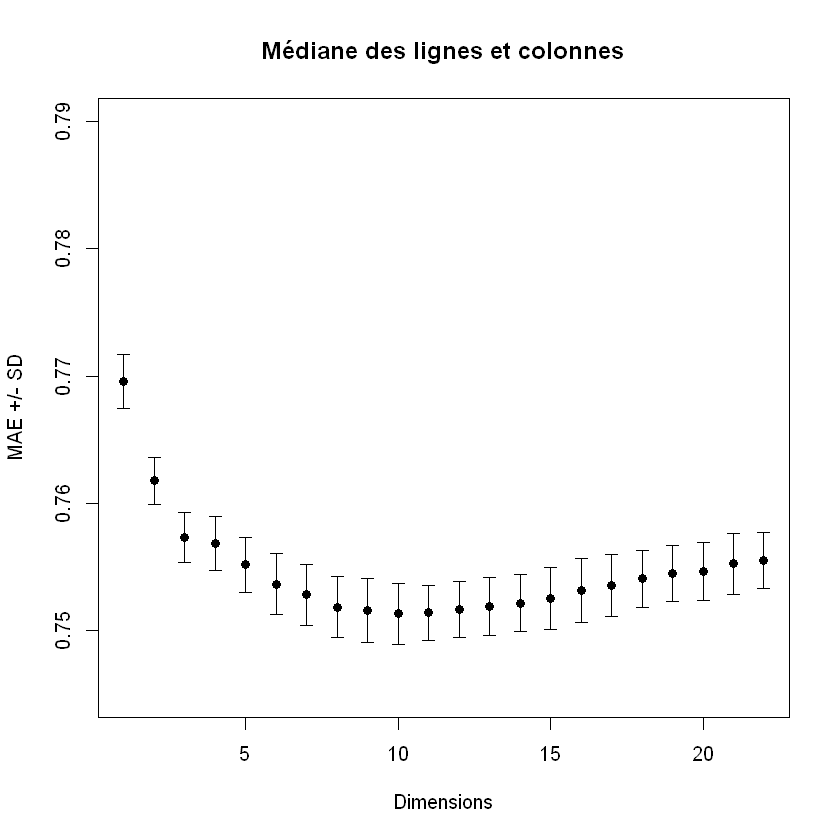

In [11]:
# graphique
plot(x,avg,ylim = c(0.745, 0.79),pch=19, xlab="Dimensions", ylab="MAE +/- SD",
    main="Médiane des lignes et colonnes"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

Moyenne du MAE pour les 5fold

In [8]:
mean(cv.b)

[1] 0.7711742

Moyenne du MAE par dimension pour les 5fold

In [9]:
avg

[1] 0.7695645 0.7617928 0.7573532 0.7568656 0.7551929 0.7536726 0.7528329
 [8] 0.7518733 0.7516097 0.7513474 0.7514113 0.7516519 0.7519087 0.7521769
[15] 0.7525569 0.7531642 0.7535683 0.7540891 0.7544880 0.7546770 0.7552581
[22] 0.7555454

On ecrit la valeur dans un fichier pour utilisation future

In [ ]:
write.table(avg, file="out/total/median.csv",sep="")